# Stiffness, convergence, stability and unitarity

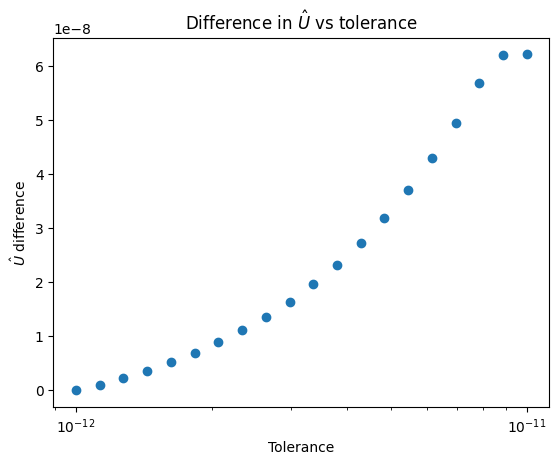

As this graph showed, using RK45 with smaller tolerances makes the resulting solution for $\hat{U}$ converge. Making the tolerance smaller forces scipy to take smaller time steps which in turn decreases the error of the RK45 method. 

It is important to consider that there are many other ODE solvers out the, some of them are very accurate but less efficient and viceversa. At this point I had to ask why use RK4 when maybe DOP853 could produce more accurate results in the same amount of time, since both of them are Runge-Kutta methods. Other methods use information from all previous steps to find a solution and may be more accurate (Linear multistep methods). From what I have gathered, there are many types of numerical ODE solvers, broadly divided into two groups:

1. Single-Step Methods (Runge-Kutta Family)

These methods use only information at $t_n$ to calculate $y_{n+1}$. This makes them self-starting and easy to adjust the step size, making them the foundation of modern adaptive solvers like those in SciPy.

A. Explicit Runge-Kutta (ERK)

  *  Mechanism: Uses only known values ($y_n$) to estimate intermediate function slopes ($k_i$) and explicitly calculate the next step.

  *  The TDSE Winner: Because for our system the function evaluation $\mathbf{f}(t, \mathbf{y})$ is just a matrix-vector product ($-\mathbf{i}\mathbf{H}\mathbf{y}$). This is cheap ($\approx \mathcal{O}(N_{\text{states}}^2)$ or better if sparse).

  *  Best Options: DOP853 , RK45.

B. Implicit Runge-Kutta (IRK)

  *  Mechanism: The calculation of the next step $y_{n+1}$ depends on $y_{n+1}$ itself, leading to a system of non-linear algebraic equations.

  *  The Cost: This requires solving a matrix equation involving the Jacobian ($\mathbf{J}=-i\mathbf{H}$) at every step using methods like Newton's iteration. This requires solving a linear system, incurring a massive cost of $\approx \mathcal{O}(N_{\text{states}}^3)$.

  *  Best Option: Radau (Extremely stable, L-stable property makes it effective for dissipating the stiff components).

1. Linear Multistep Methods (LMMs)

These methods use $k$ prior solution values ($y_{n}, y_{n-1}, \dots, y_{n-k+1}$) to predict the next value $y_{n+1}$.

A. Adams Family (Non-Stiff)

  *  Method: Adams-Bashforth (Explicit) and Adams-Moulton (Implicit).

  *  Benefit: They can achieve very high orders (up to 12 in SciPy's LSODA), making them highly efficient if you require extreme accuracy, as a single high-order step is equivalent to many low-order steps.

B. Backward Differentiation Formulas (BDF) (Stiff)

  *  Method: A separate LMM family specifically designed to manage classical stiffness.

  *  Cost & Drawback: Like IRK methods, they are implicit and require the $\approx \mathcal{O}(N_{\text{states}}^3)$ Jacobian operation, making them too slow for large TDSE systems.


Assuming that the point of running these simulations is to show that running these types of simulations would be much easier by building an analogous system with a set of QuBits. Then we should aim to run them as efficiently as possible, to show that in spite of all these improvements, they become exponentially larger (and hence computationally heavy). Secondly, it seems from the list above that Runge-Kutta methods are the best option here. Having shown that the RK45 solution converges it might also be worth estimating at which timesteps size does the solution become unstable. There is actually a way to check for this. First, let's create the Hamiltonian

In [18]:
import numpy as np
import time
import os
from scipy.sparse import (
    identity as sparse_identity,
    diags as sparse_diags,
    kron as sparse_kron,
    csc_matrix,
    eye as sparse_eye
)
from scipy.sparse.linalg import expm as sparse_expm
from scipy.integrate import solve_ivp, RK45
from scipy.integrate._ivp.base import OdeSolver
from functools import reduce # Needed for sparse.kron reduction
import sys
from pathlib import Path
# Add the project root directory to Python path
notebook_path = Path().absolute()  # Gets the current notebook directory
project_root = notebook_path.parent  # Goes up one level to project root
sys.path.append(str(project_root))
from utils.funcs import load_params
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh

In [28]:
# --- SciPy/NumPy Operator Definitions ---

def sparse_destroy(dim):
    """Creates a sparse destruction operator."""
    if dim <= 0:
        raise ValueError("Dimension must be > 0")
    if dim == 1:
        return csc_matrix((1, 1), dtype=np.complex128)
    data = np.sqrt(np.arange(1, dim, dtype=np.complex128))
    offsets = [1]
    # FIX: Wrap 'data' in a list to match the list 'offsets'
    return sparse_diags([data], offsets, shape=(dim, dim), format='csc')

def sparse_num(dim):
    """Creates a sparse number operator."""
    if dim <= 0:
        raise ValueError("Dimension must be > 0")
    if dim == 1:
        return csc_matrix((1, 1), dtype=np.complex128)
    data = np.arange(dim, dtype=np.complex128)
    offsets = [0]
    # FIX: Wrap 'data' in a list to match the list 'offsets'
    return sparse_diags([data], offsets, shape=(dim, dim), format='csc')

def get_sparse_op(op, site, dims):
    """
    Creates a full-system sparse operator from a local operator
    using sparse.kron.
    """
    op_list = [sparse_identity(d, dtype=np.complex128, format='csc') for d in dims]
    op_list[site] = op
    return reduce(sparse_kron, op_list)

def propagator_ode_real(t, y_real, H0, H1, W, nu_delta, D):
    """
    The ODE function for the propagator U(t), compatible with solve_ivp.
    It evolves dU/dt = -i * H(t) * U(t)
    
    y_real = [U_flat_real, U_flat_imag] (size 2 * D*D)
    """
    D_sq = D * D
    # Reconstruct the complex flattened vector
    U_flat_complex = y_real[:D_sq] + 1j * y_real[D_sq:]
    
    # Reshape into a D x D matrix
    # We use 'F' (Fortran) order to match the flattening,
    # which is standard for quantum mechanics state vectors vs operators.
    U = U_flat_complex.reshape((D, D), order='F')
    
    # Calculate H(t)
    H_t = H0 + H1 * (W * np.cos(nu_delta * t))
    
    # Calculate dU/dt = -i * H(t) * U
    # H_t is (D, D), U is (D, D). Use matrix multiplication
    dU_dt_complex = -1j * (H_t @ U)
    
    # Flatten the complex derivative
    dU_dt_flat = dU_dt_complex.flatten(order='F')
    
    # Split back into real and imaginary parts
    return np.concatenate([dU_dt_flat.real, dU_dt_flat.imag])

def build_H(params):

    N = int(params['N'])
    n_max_transmon = int(params['n_max_transmon'])
    n_max_resonator = int(params['n_max_resonator'])

    eta = float(params['eta'])
    phiq = float(params['phiq'])
    phia = eval(str(params['phia']))
    J = eval(str(params['J']))
    nu = eval(str(params['nu']))
    delta = eval(str(params['delta']))
    de = float(params['de']) * delta
    wq = eval(str(params['wq']))
    EJ = eval(str(params['EJ']))

    # --- System Definition ---
    dims = [n_max_transmon if i % 2 == 0 else n_max_resonator for i in range(2 * N)]
    D_total = np.prod(dims)

    En = []
    for i in range(N):
        En.append(wq + i * de)
        En.append(nu)
    En = np.array(En)

    # --- Local Operators (Sparse) ---

    a_t = sparse_destroy(n_max_transmon)
    a_t_dag = a_t.conj().T.tocsc() 
    n_t = sparse_num(n_max_transmon)
    x_t = a_t_dag + a_t           

    a_r = sparse_destroy(n_max_resonator)
    a_r_dag = a_r.conj().T.tocsc() 
    n_r = sparse_num(n_max_resonator)
    x_r = a_r_dag + a_r           

    print(f"Total Hilbert space dimension: {D_total}")

    # --- Build Hamiltonian (Sparse) ---
    print("Building sparse H0...")
    # On-site energies
    H0 = csc_matrix((D_total, D_total), dtype=np.complex128)
    for i in range(2 * N):
        if i % 2 == 0:  # Transmon site
            H0 += En[i] * get_sparse_op(n_t, i, dims)
        else:  # Resonator site
            H0 += En[i] * get_sparse_op(n_r, i, dims)

    # EJ term: -0.5*EJ*(phi^2 + cos(phi))
    phi_squared_sum = csc_matrix((D_total, D_total), dtype=np.complex128)
    cos_phi_sum = csc_matrix((D_total, D_total), dtype=np.complex128)

    for i in range(N):
        print(f"Building phi term for site {i}...")
        # phi_op for the i-th Transmon-Resonator pair
        phi_op = (
            phiq * get_sparse_op(x_t, 2 * i, dims) + 
            phia * get_sparse_op(x_r, 2 * i + 1, dims)
        )
        
        # Contribution to the sum of phi^2 terms
        phi_squared_sum += phi_op * phi_op
        
        # Contribution to the sum of cos(phi) terms
        # This is the computationally heavy step
        print(f"Calculating matrix exponential for site {i}...")
        U_phi = sparse_expm(-1j * phi_op)
        cos_phi_sum += 0.5 * (U_phi + U_phi.conj().T)
        print(f"Done with site {i}.")

    H0 += EJ * (0.5 * phi_squared_sum + cos_phi_sum)

    # J coupling term
    for i in range(N - 1):
        H0 += J * get_sparse_op(x_t, 2 * i, dims) * get_sparse_op(x_t, 2 * i + 2, dims)

    print("Building sparse H1...")
    # Time-dependent part of Hamiltonian
    H1 = csc_matrix((D_total, D_total), dtype=np.complex128)
    for i in range(N):
        H1 += get_sparse_op(x_t, 2 * i, dims)

    return H0, H1

def initial_state(params):

    N = int(params['N'])
    n_max_transmon = int(params['n_max_transmon'])
    n_max_resonator = int(params['n_max_resonator'])

    # --- System Definition ---
    dims = [n_max_transmon if i % 2 == 0 else n_max_resonator for i in range(2 * N)]

    # --- Build Initial State (NumPy) ---
    psi_list = []
    for i in range(2 * N):
        dim_i = dims[i] # Get the correct dimension for the site
        state_vec = np.zeros(dim_i, dtype=np.complex128)
        if i == 0:
            state_vec[1] = 1.0 # Transmon 1 is |1>
        else:
            state_vec[0] = 1.0 # All others are |0>
        psi_list.append(state_vec)

    # Use reduce with np.kron for the state vector
    psi0_vec = reduce(np.kron, psi_list)

    return psi0_vec

def get_number_ops(params):
    
    N = int(params['N'])
    n_max_transmon = int(params['n_max_transmon'])
    n_max_resonator = int(params['n_max_resonator'])

    # --- System Definition ---
    dims = [n_max_transmon if i % 2 == 0 else n_max_resonator for i in range(2 * N)]

    n_t = sparse_num(n_max_transmon)
    n_r = sparse_num(n_max_resonator)

    # --- Build Observables (Sparse) ---
    number_ops = []
    for i in range(2 * N):
        if i % 2 == 0:
            number_ops.append(get_sparse_op(n_t, i, dims))
        else:
            number_ops.append(get_sparse_op(n_r, i, dims))

    return number_ops

def plot_sim(njt, tlist):
    # --- Create Plot ---
    fig, ax = plt.subplots(figsize=(12, 6))

    for i in range(njt.shape[1]):
        if i % 2 == 0:  # Transmon site
            label_base = f'Transmon_{i//2 + 1}'
            plot_label = f'<n> Transmon {i//2 + 1}'
        else:  # Resonator site
            label_base = f'Resonator_{i//2 + 1}'
            plot_label = f'<n> Resonator {i//2 + 1}'

        expect_values = njt[:,i]
        ax.plot(tlist, expect_values, label=plot_label)

    # --- Configure and Show Plot ---
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Population")
    ax.legend(loc='upper left')
    ax.grid(True)
    plt.show()

def get_ode_args():
    """Helper to package arguments for the solver."""
    return (H0, H1, W, nu_delta, D_total)

def reconstruct_U(y_flat, dim):
    """Helper to reshape flat real solution back to complex unitary."""
    D_sq = dim * dim
    U_flat = y_flat[:D_sq] + 1j * y_flat[D_sq:]
    return U_flat.reshape((dim, dim), order='F')

from scipy.integrate._ivp.base import OdeSolver

class CustomRK4(OdeSolver):
    """
    A custom Runge-Kutta 4 solver with a fixed step size (h), implemented 
    as a subclass of SciPy's internal OdeSolver base class.
    
    This solver is selected by setting 'solver_method': 'CUSTOM_RK4'.
    The fixed step size h is derived from the 'usteps' parameter.
    """
    
    order = 4 # Order of the integration method
    
    def __init__(self, fun, t0, y0, t_bound, vectorized, **extraneous):
        # Initialize base class (handles fun, t0, y0, t_bound, vectorized)
        h = extraneous.pop('max_step', np.inf)         
        # 'max_step' passed by solve_ivp will be used here to convey the fixed step size 'h'
        if h == np.inf:
            raise ValueError("CustomRK4 requires a finite step size (h). Check 'usteps' calculation.")
        
        super().__init__(fun, t0, y0, t_bound, vectorized, **extraneous)
        self.h = h
        
    def _step_impl(self):
        """Performs one fixed-size RK4 step."""
        t, y = self.t, self.y
        h = self.h
        
        # Check if the step would go beyond the boundary
        if t + h >= self.t_bound:
            h = self.t_bound - t
            if h <= 1e-15: # Time step is effectively zero
                self.status = 'finished'
                return False, False # Stop integration
        
        # RK4 coefficients calculation
        try:
            k1 = self.fun(t, y)
            k2 = self.fun(t + h / 2, y + h * k1 / 2)
            k3 = self.fun(t + h / 2, y + h * k2 / 2)
            k4 = self.fun(t + h, y + h * k3)
        except Exception as e:
            self.status = 'failed'
            self.message = f"Error during RHS evaluation in CustomRK4: {e}"
            return False, False

        # Update y using RK4 formula
        self.y += h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        self.t += h
        
        # Check if we reached the boundary (or very close)
        if self.t >= self.t_bound - 1e-15:
            self.status = 'finished'

        # Success=True, Error_estimate=False (fixed step)
        return True, False 

    def _dense_output_impl(self):
        # Dense output is not implemented or required for this use case.
        return None

In [20]:
# --- Evaluate parameters ---
params = load_params('example.json')

# --- System hamiltonian ---
H0, H1 = build_H(params)

# --- Initial state vector ---
psi0_vec = initial_state(params)

# --- Number operators ---
number_ops = get_number_ops(params)

Total Hilbert space dimension: 256
Building sparse H0...
Building phi term for site 0...
Calculating matrix exponential for site 0...
Done with site 0.
Building phi term for site 1...
Calculating matrix exponential for site 1...
Done with site 1.
Building sparse H1...


### Stability of Explicit Runge-Kutta Methods

When using Explicit Runge-Kutta methods like RK45 and DOP853, stability is the primary constraint imposed by the physics of your system.

#### Stability Definition and Translation: The Test Equation

To analyze the stability of any explicit method, we first apply it to the scalar test equation:


$$\frac{dy}{dt} = \lambda y$$


where $\lambda$ is a complex eigenvalue of the Jacobian. When a Runge-Kutta method is applied over a single step $h$, the numerical solution $y_{n+1}$ is related to $y_n$ by an amplification factor $R(z)$:


$$y_{n+1} = R(z) y_n, \quad \text{where } z = h\lambda$$


For a 4th-order method (like the core of RK45), the amplification factor $R(z)$ is the Taylor series approximation of $e^z$ up to the fourth order:


$$R(z) = 1 + z + \frac{z^2}{2!} + \frac{z^3}{3!} + \frac{z^4}{4!}$$

The method is absolutely stable if the magnitude of the numerical solution does not grow spuriously. This requires the magnitude of the amplification factor to be less than or equal to one:


$$|R(z)| \le 1$$


The set of all $z$ values satisfying this condition is the Region of Absolute Stability (ROS).

For the Time-Dependent Schrödinger Equation (TDSE), the Jacobian is $\mathbf{J} = -i\mathbf{H}(t)$, so its eigenvalues are purely imaginary:


$$\lambda_n = -i\mathbf{E}_n$$


where $\mathbf{E}_n$ are the real eigenvalues of the Hamiltonian. This means the scaled eigenvalues, $z = h\lambda = -ih\mathbf{E}_n$, all lie exactly on the imaginary axis of the complex plane.

The RK4 ROS crosses the imaginary axis at approximately $\pm 2.82$. To ensure stability for all components of the solution, the maximum scaled eigenvalue must remain within this boundary:


$$|z_{max}| = h \cdot \max_{n}|\lambda_n| = h \cdot \rho(\mathbf{H}) \le 2.82$$


where $\rho(\mathbf{H})$ is the spectral radius (maximum energy gap) of the Hamiltonian.

This directly determines the maximum stable time step for an explicit solver:


$$h_{max} \le \frac{2.82}{\rho(\mathbf{H})}$$

If the time step $h$ required to meet the user's accuracy tolerance ($\text{rtol}/\text{atol}$) is larger than $h_{max}$, the solver is stability-limited and must decrease the step size until stability is guaranteed. If the time step required for accuracy is smaller than $h_{max}$, the solver is accuracy-limited and remains stable. Let's see if this is true for our implementation.

Total Hilbert space dimension: 256
Building sparse H0...
Building phi term for site 0...
Calculating matrix exponential for site 0...
Done with site 0.
Building phi term for site 1...
Calculating matrix exponential for site 1...
Done with site 1.
Building sparse H1...
--- Plotting Stable Case (RK4) ---


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Users\Gonzalo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


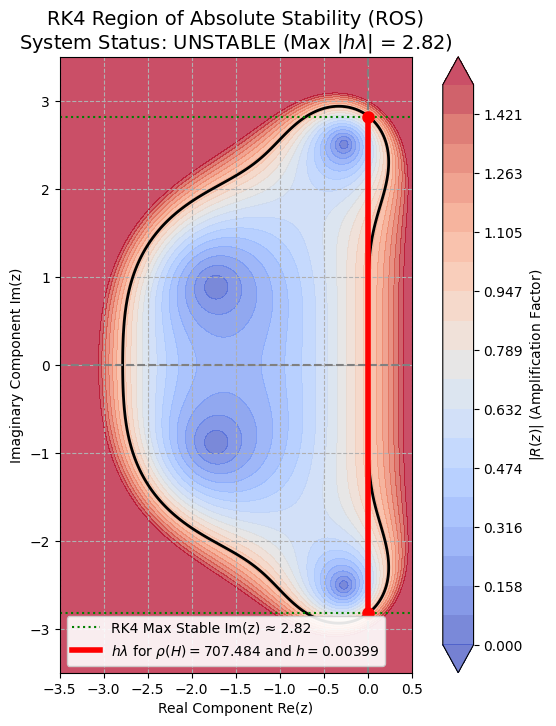

In [56]:

# Run this check using your variables
# Simulation settings
sim_length = params['sim_length']
usteps = params['usteps']
N = params['N']
n_max_transmon = params['n_max_transmon']
n_max_resonator = params['n_max_resonator']

# Physical constants
eta = float(params['eta'])
nu = eval(str(params['nu']))
delta = eval(str(params['delta']))
de = float(params['de']) * delta
wq = eval(str(params['wq']))

W = eta * (wq**2 - (nu - delta)**2) / (2 * wq)
nu_delta = nu - delta
period = 2 * np.pi / nu_delta

# Number of steps for one period propagation
usteps = int(params['usteps'])

# --- Set up Time List for one period ---
usteps = 60
tlist_one_period = np.linspace(0, period, usteps)

# Calculate the step size used for evaluation points
U_dt = tlist_one_period[1] - tlist_one_period[0]
params['U_dt'] = U_dt

# --- Set up stroboscopic time list for full evolution ---
tUsteps = int(sim_length / period)
tlist = np.linspace(0, tUsteps * period, tUsteps + 1)
params['sim_dt'] = period


def rk4_stability_function(z):
    """
    Calculates the Amplification Factor R(z) for the 4th-order Runge-Kutta (RK4) method.
    
    R(z) = 1 + z + z^2/2! + z^3/3! + z^4/4!
    
    The stability region is defined where |R(z)| <= 1.
    """
    return 1 + z + z**2 / 2.0 + z**3 / 6.0 + z**4 / 24.0

def plot_absolute_stability_region(max_energy_gap=3.0, dt_check=0.001):
    """
    Plots the Region of Absolute Stability (ROS) for RK4.

    Args:
        max_energy_gap (float): The spectral radius of the Hamiltonian, rho(H) (in GHz).
                                Max frequency of oscillation.
        dt_check (float): The time step (in ns) you want to evaluate.
    """
    
    # 1. Define the complex plane grid for z = h * lambda
    # The RK4 region extends to approx -2.8 on the Real axis (Re(z)) and +/- 2.82 on the Imaginary axis (Im(z)).
    x_min, x_max = -3.5, 0.5
    y_min, y_max = -3.5, 3.5
    
    # Create a grid of complex numbers
    n_points = 500
    x = np.linspace(x_min, x_max, n_points)
    y = np.linspace(y_min, y_max, n_points)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y

    # 2. Calculate the magnitude of the amplification factor |R(z)|
    R_magnitude = np.abs(rk4_stability_function(Z))

    # 3. Create the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Contour map showing |R(z)|. The level=1 contour defines the boundary of the ROS.
    contour = ax.contourf(X, Y, R_magnitude, levels=np.linspace(0, 1.5, 20), cmap='coolwarm', extend='both', alpha=0.7)
    
    # Highlight the boundary of the ROS: |R(z)| = 1
    ax.contour(X, Y, R_magnitude, levels=[1.0], colors='k', linestyles='-', linewidths=2)
    
    # Mark the Region of Absolute Stability (ROS)
    # The ROS is where the contour values are <= 1
    
    # 4. Highlight key axes and stability constraints
    ax.axhline(0, color='gray', linestyle='--') # Real axis (Re(z))
    ax.axvline(0, color='gray', linestyle='--') # Imaginary axis (Im(z))
    
    # Add a marker for the imaginary axis stability limit (where your eigenvalues live)
    rk4_imag_limit = 2.82 # The RK4 region crosses the imaginary axis at approx +/- 2.82
    ax.axhline(rk4_imag_limit, color='g', linestyle=':', label=f'RK4 Max Stable Im(z) ≈ {rk4_imag_limit:.2f}')
    ax.axhline(-rk4_imag_limit, color='g', linestyle=':')
    
    # 5. Plot the physical stability requirement (z = h * lambda)
    # Since lambda = -i * E, our z values are z = -i * dt * E, which lie on the imaginary axis.
    
    # The critical point z_critical = i * dt_check * rho(H)
    z_critical = max_energy_gap * dt_check
    
    ax.plot([0, 0], [-z_critical, z_critical], 
            'r-', linewidth=4, 
            label=f'$h\lambda$ for $\\rho(H)={max_energy_gap:.3f}$ and $h={dt_check:.5f}$')
    ax.plot(0, z_critical, 'ro', markersize=8)
    ax.plot(0, -z_critical, 'ro', markersize=8)
    
    # Check Stability
    is_stable = z_critical < rk4_imag_limit
    stability_status = "STABLE" if is_stable else "UNSTABLE"
    
    # 6. Final Plot Aesthetics
    ax.set_title(f'RK4 Region of Absolute Stability (ROS)\nSystem Status: {stability_status} (Max $|h\lambda|$ = {z_critical:.2f})', fontsize=14)
    ax.set_xlabel('Real Component Re(z)')
    ax.set_ylabel('Imaginary Component Im(z)')
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--')
    ax.legend(loc='lower left', framealpha=0.9)
    plt.colorbar(contour, ax=ax, label='$|R(z)|$ (Amplification Factor)')
    plt.show()

# --- Execution Example ---

# Define the maximum frequency (spectral radius of H) and the time step to check
# NOTE: These values are illustrative. Use the max_energy_gap calculated in the previous step.

# Case 1: Stable Example (low frequency or small dt)
# 1. Build H0 and H1 (Assuming N=1 for simplicity/speed)
H0, H1 = build_H(params)

# 2. Construct the Effective Hamiltonian at peak drive (H_eff = H0 + W * H1)
# The spectral radius of H is maximized when the driving term is maximal (cos(wt)=1).
H_eff = H0 + H1 * W 

# 3. Calculate Eigenvalues
# We use 'LM' (Largest Magnitude) to find the largest E.
# The Hamiltonian is Hermitian, so eigenvalues are real.

# Request k=5 for a sample of the largest eigenvalues
k_val = min(H_eff.shape[0] - 2, 5) 
if k_val < 1:
    raise ValueError("Matrix too small for eigsh.")
    
E_vals_largest = eigsh(H_eff.real, k=k_val, which='LM', return_eigenvectors=False)
E_max = np.max(np.abs(E_vals_largest))



rho_H_stable = E_max # GHz
dt_stable = 2.82/E_max # ns
print("--- Plotting Stable Case (RK4) ---")
plot_absolute_stability_region(max_energy_gap=rho_H_stable, dt_check=dt_stable)

# Case 2: Unstable Example (high frequency or large dt)
# rho_H_unstable = 1000.0 # GHz (simulating a very stiff/high-frequency component)
# dt_unstable = 0.01 # ns
# print("\n--- Plotting Unstable Case (RK4) ---")
# plot_absolute_stability_region(max_energy_gap=rho_H_unstable, dt_check=dt_unstable)

In [ ]:
"""
Calculates the eigenvalues of the Jacobian J = -iH and checks stiffness.
"""

# Extract constants
W = float(params.get('W', 0.1))
U_dt = float(params.get('U_dt', 0.01))
print('balbalabalab')
print(U_dt)
D_total = np.prod([params.get('n_max_transmon', 3), params.get('n_max_resonator', 3)])

print(f"--- Stiffness Analysis for D={D_total} ---")
print(f"Parameters: Time Step={U_dt} ns, Drive Amplitude={W}")

# 1. Build H0 and H1 (Assuming N=1 for simplicity/speed)
H0, H1 = build_H(params)

# 2. Construct the Effective Hamiltonian at peak drive (H_eff = H0 + W * H1)
# The spectral radius of H is maximized when the driving term is maximal (cos(wt)=1).
H_eff = H0 + H1 * W 

# 3. Calculate Eigenvalues
# We use 'LM' (Largest Magnitude) to find the largest E.
# The Hamiltonian is Hermitian, so eigenvalues are real.

# Request k=5 for a sample of the largest eigenvalues
k_val = min(H_eff.shape[0] - 2, 5) 
if k_val < 1:
    raise ValueError("Matrix too small for eigsh.")
    
E_vals_largest = eigsh(H_eff.real, k=k_val, which='LM', return_eigenvectors=False)
E_max = np.max(np.abs(E_vals_largest))
    


# 4. Analyze Jacobian Eigenvalues (lambda = -i * E)
# Stiff: Separation in Re(lambda). Not applicable here.
# Pseudostiff/Oscillatory: Magnitude of Im(lambda).

rho_H = E_max # Spectral Radius of H (Max energy)
stability_product_z = U_dt * rho_H

# 5. Determine stability limits for RK45 (explicit)
RK4_limit_C = 2.82 # Stability region limit on imaginary axis

print("\n--- Eigenvalue Results (Energy Gaps in GHz) ---")
print(f"Maximum Energy Gap (Spectral Radius, ρ(H)): {rho_H:.4f} GHz")
if len(E_vals_largest) > 0:
    print(f"Sample Largest Eigenvalues: {E_vals_largest.round(4)}")

print("\n--- Stiffness/Stability Check ---")
print(f"Max Jacobian Magnitude (Max Oscillation Frequency): {rho_H:.4f} GHz")
print(f"RK45 Stability Product (z = dt * ρ(H)): {stability_product_z:.4f}")

if stability_product_z > RK4_limit_C:
    print(f"\nCONCLUSION: The problem is highly **Pseudostiff** (Oscillatory Stiff).")
    print(f"An Explicit solver like RK45 is **Potentially UNSTABLE** at this step size.")
    print(f"Required max step size for stability: {RK4_limit_C / rho_H:.4f} ns.")
    print("Recommendation: Use an A-stable method (e.g., `BDF` or `Radau`) for efficiency.")
else:
    print(f"\nCONCLUSION: The problem is **Pseudostiff**, but **Numerically Stable**.")
    print(f"The explicit RK45 solver is **STABLE** at this step size (0.01 ns).")
    print("Step size is likely limited by ACCURACY, not stability.")
    print("Recommendation: Use `RK45` or `DOP853` for speed.")
    


balbalabalab
0.0023628000767075574
--- Stiffness Analysis for D=16 ---
Parameters: Time Step=0.0023628000767075574 ns, Drive Amplitude=0.1
Total Hilbert space dimension: 256
Building sparse H0...
Building phi term for site 0...
Calculating matrix exponential for site 0...
Done with site 0.
Building phi term for site 1...
Calculating matrix exponential for site 1...
Done with site 1.
Building sparse H1...

--- Eigenvalue Results (Energy Gaps in GHz) ---
Maximum Energy Gap (Spectral Radius, ρ(H)): 706.4907 GHz
Sample Largest Eigenvalues: [660.4121 660.4151 678.8999 680.542  706.4907]

--- Stiffness/Stability Check ---
Max Jacobian Magnitude (Max Oscillation Frequency): 706.4907 GHz
RK45 Stability Product (z = dt * ρ(H)): 1.6693

CONCLUSION: The problem is **Pseudostiff**, but **Numerically Stable**.
The explicit RK45 solver is **STABLE** at this step size (0.01 ns).
Step size is likely limited by ACCURACY, not stability.
Recommendation: Use `RK45` or `DOP853` for speed.


c:\Users\Gonzalo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
c:\Users\Gonzalo\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


In [29]:

# 1. Construct H at t=0 (usually the stiffest point or indicative of the max E)
# Note: If H is time-dependent, the max eigenvalue might change, 
# but H0 usually dominates the energy scale.
H_total = H0 + H1 

# 2. Find the largest eigenvalue (Spectral Radius)
# 'LM' = Largest Magnitude
print("Calculating spectral radius (this may take a moment)...")
eig_vals = eigsh(H_total, k=1, which='LM', return_eigenvectors=False)
max_energy = np.abs(eig_vals[0])

# 3. Calculate the stability factor z
z = U_dt * max_energy

print(f"Max Energy Eigenvalue (rho): {max_energy:.4e}")
print(f"Time step (dt): {U_dt:.4e}")
print(f"Stability product (dt * rho): {z:.4f}")

# The imaginary axis stability limit for RK4 is approx 2.8
limit_rk4 = 2.8

if z < limit_rk4:
    print(f"✅ STABLE: {z:.4f} < {limit_rk4}")
else:
    print(f"❌ UNSTABLE: {z:.4f} > {limit_rk4}. Decrease dt.")


Calculating spectral radius (this may take a moment)...
Max Energy Eigenvalue (rho): 7.0674e+02
Time step (dt): 2.3628e-03
Stability product (dt * rho): 1.6699
✅ STABLE: 1.6699 < 2.8


I_flat shape: (65536,), expected: (65536,)
y0_real shape: (131072,), expected: (131072,)
Generating reference solution...
100
100


C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_23004\3684852192.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


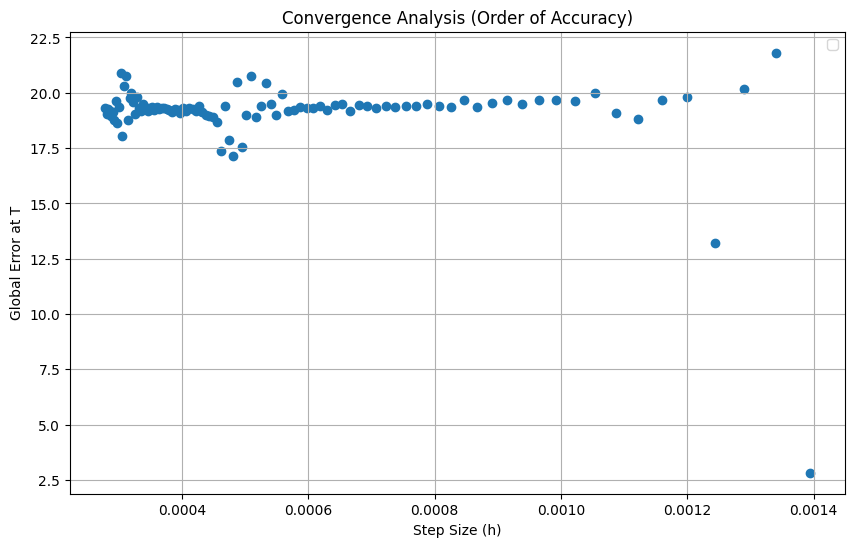

In [96]:
# 1. Construct H at t=0 (usually the stiffest point or indicative of the max E)
# --- System Definition ---
dims = [n_max_transmon if i % 2 == 0 else n_max_resonator for i in range(2 * N)]
D_total = np.prod(dims)
D_sq = D_total * D_total
# Initial state is the flattened identity matrix
I_flat = sparse_eye(D_total, D_total, dtype=np.complex128, format='csc').toarray().flatten(order='F')

# Ensure I_flat has the correct shape: should be (D_total * D_total,)
print(f"I_flat shape: {I_flat.shape}, expected: ({D_total * D_total},)")
assert I_flat.shape[0] == D_total * D_total, "I_flat dimension mismatch!"

y0_real = np.concatenate([I_flat.real, I_flat.imag])
print(f"y0_real shape: {y0_real.shape}, expected: ({2 * D_total * D_total},)")

# Dictionary to store results
solver_results = {}
# Define a list of decreasing step sizes
# We calculate steps per period: 10, 20, 40, 80
steps_per_period = np.linspace(100, 500, 100)
# steps_per_period = np.append(steps_per_period,np.linspace(50,500,100), axis=0)
h_values = [period / s for s in steps_per_period]
    
errors = []
    
# Get High-Precision Reference (using very tight tolerance adaptive)
ode_args = get_ode_args()
    
print("Generating reference solution...")
sol_ref = solve_ivp(
    lambda t, y: propagator_ode_real(t, y, *ode_args),
    (0, period),
    y0_real,
    method='DOP853',
    rtol=1e-12,
    atol=1e-12
)

U_ref = reconstruct_U(sol_ref.y[:, -1], D_total)
for h in h_values:
    # Force fixed steps using method='RK45' but constraining max_step
    # Note: Ideally we use the CustomRK4 class, but forcing RK45 works for demonstration
    sol = solve_ivp(
    propagator_ode_real,
    t_span=[0, tlist_one_period[-1]],
    y0=y0_real,
    args=ode_args,
    method=CustomRK4,
    max_step=h,
    dense_output=False
    )
        
    U_approx = reconstruct_U(sol.y[:, -1], D_total)
        
    # Calculate Frobenius norm of difference
    err = np.linalg.norm(U_approx - U_ref)
    errors.append(err)
    # print(f"h = {h:.2e}, Error = {err:.2e}")

# Plotting
plt.figure(figsize=(10, 6))
print(len(h_values))
print(len(errors))
plt.scatter(h_values, errors)

# Plot theoretical 4th and 5th order slopes
h_arr = np.array(h_values)
# plt.plot(h_arr, errors[-1] * (h_arr/h_arr[-1])**4, '--', label='O(h^4) Slope')
# plt.plot(h_arr, errors[-1] * (h_arr/h_arr[-1])**5, '--', label='O(h^5) Slope')
    
plt.xlabel('Step Size (h)')
plt.ylabel('Global Error at T')
plt.title('Convergence Analysis (Order of Accuracy)')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()


--- Running Unitarity Stability Test (multiple solvers) ---

Running solver: CustomRK4_fixed
  finished in 3.533s with 233 saved steps


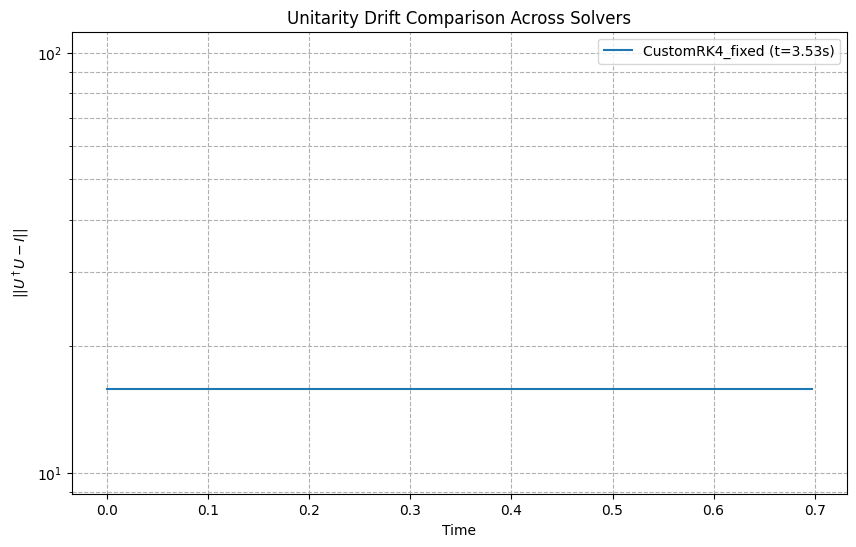

In [92]:
# ...existing code...
# --- 2. Unitarity Stability Test ---
print("\n--- Running Unitarity Stability Test (multiple solvers) ---")

ode_args = get_ode_args()
y0 = np.concatenate([I_flat.real, I_flat.imag])

# Run for a longer time (e.g., 5 periods) to see drift
long_T = 5 * period
# Instead of period / usteps, set U_dt to what we used previusly 0.0001
U_dt = 0.003
# Solver configurations

solvers = [
    ("CustomRK4_fixed", {"method": CustomRK4, "max_step": U_dt, "vectorized": True}),
    # ("RK23", {"method": "RK23", "rtol": 1e-9, "atol": 1e-9, "vectorized": True}),
    # ("RK45", {"method": "RK45", "rtol": 1e-6, "atol": 1e-8, "vectorized": True}),
    # ("Radau", {"method": "Radau", "rtol": 1e-10, "atol": 1e-10, "vectorized": True}),
    # ("BDF", {"method": "BDF", "rtol": 1e-10, "atol": 1e-10, "vectorized": True}),
    # ("DOP853", {"method": "DOP853", "rtol": 1e-12, "atol": 1e-12, "vectorized": True}),
]

results = {}

for name, opts in solvers:
    print(f"\nRunning solver: {name}")
    start = time.time()

    # Build kwargs for solve_ivp -- DO NOT pass t_eval (avoids preallocating huge arrays)
    solve_kwargs = dict(
        fun=lambda t, y: propagator_ode_real(t, y, *ode_args),
        t_span=(0.0, long_T),
        y0=y0,
        # leave t_eval=None so solve_ivp will store its internal timesteps only
    )
    # Merge options (method, max_step, rtol, atol, vectorized)
    solve_kwargs.update(opts)

    try:
        sol = solve_ivp(**solve_kwargs)
    except MemoryError as me:
        print(f"Solver {name} failed with MemoryError: {me}")
        continue
    except Exception as e:
        print(f"Solver {name} failed: {e}")
        continue

    elapsed = time.time() - start
    print(f"  finished in {elapsed:.3f}s with {len(sol.t)-1} saved steps")

    # Compute unitarity drift ||U^† U - I|| for each saved time (use sol.t to avoid extra memory)
    unitarity_errors = []
    Id = np.eye(D_total, dtype=np.complex128)
    for k in range(sol.y.shape[1]):
        U_k = reconstruct_U(sol.y[:, k], D_total)
        dev = U_k.conj().T @ U_k - Id
        unitarity_errors.append(np.linalg.norm(dev))

    results[name] = {"time": elapsed, "t": sol.t, "unit_err": np.array(unitarity_errors)}

# Plot all results on same figure
plt.figure(figsize=(10, 6))
for name, res in results.items():
    plt.semilogy(res["t"], res["unit_err"], label=f"{name} (t={res['time']:.2f}s)")
plt.xlabel("Time")
plt.ylabel(r"$||U^\dagger U - I||$")
plt.title("Unitarity Drift Comparison Across Solvers")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
# ...existing code...


--- Running Perturbation Sensitivity Test ---


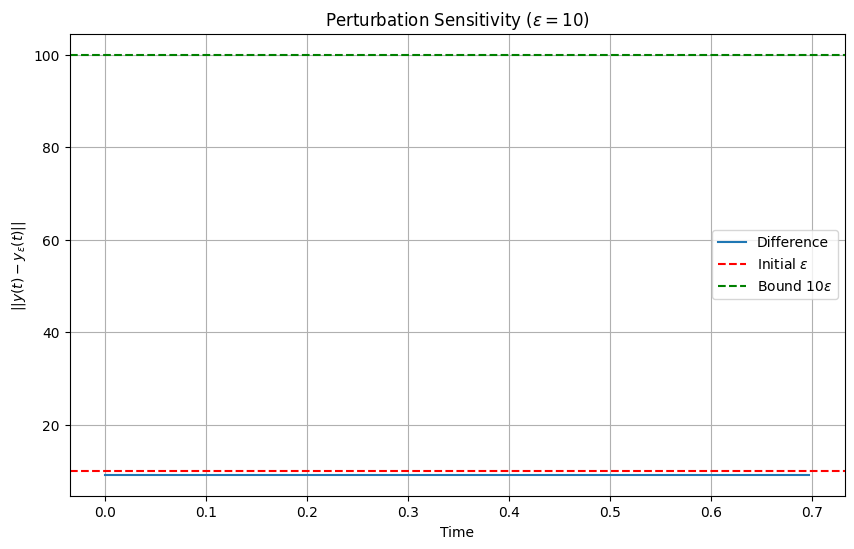

In [91]:
# --- 3. Perturbation Sensitivity (Zero-Stability) ---

print("\n--- Running Perturbation Sensitivity Test ---")
h = 0.001
ode_args = get_ode_args()
y0 = np.concatenate([I_flat.real, I_flat.imag])

# Define perturbation size epsilon
epsilon = 10

# Create random perturbation vector
perturbation = np.random.normal(0, 1, size=y0.shape)
perturbation = perturbation / np.linalg.norm(perturbation) * epsilon

y0_perturbed = y0 + perturbation

# Solve both
sol_orig = solve_ivp(
propagator_ode_real,
t_span=[0, 5*tlist_one_period[-1]],
y0=y0,
args=ode_args,
method=CustomRK4,
max_step=h,
dense_output=False
)

sol_pert = solve_ivp(
propagator_ode_real,
t_span=[0, 5*tlist_one_period[-1]],
y0=y0_perturbed,
args=ode_args,
method=CustomRK4,
max_step=h,
dense_output=False
)

# Calculate divergence
divergence = []
for i in range(len(sol_orig.t)):
    diff = np.linalg.norm(sol_orig.y[:, i] - sol_pert.y[:, i])
    divergence.append(diff)
    
plt.figure(figsize=(10, 6))
plt.plot(sol_orig.t, divergence, label='Difference')
plt.axhline(y=epsilon, color='r', linestyle='--', label='Initial $\\epsilon$')
# Check if bounded by K * epsilon (e.g. K=2)
plt.axhline(y=10*epsilon, color='g', linestyle='--', label='Bound $10\\epsilon$')

plt.xlabel('Time')
plt.ylabel('$||y(t) - y_{\\epsilon}(t)||$')
plt.title(f'Perturbation Sensitivity ($\\epsilon={epsilon}$)')
plt.legend()
plt.grid(True)
plt.show()